In [14]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [16]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [17]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/ref/'
#Path for loading individual samples
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC136*/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='VSG_ref_pp'

## Load data (filtered)

In [18]:
# Load metadata for the project
metadata=pd.read_excel('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='VSG')

In [19]:
# Find samples used for reference
samples=metadata.query('for_reference')
print('Reference samples:')
print(samples)

Reference samples:
  sample_name tissue strain   design condition              metadata  \
2    MUC13633  islet     WT  chow_WT      chow  Islets_942-1_WT_Chow   
3    MUC13634  islet     WT  chow_WT      chow  Islets_937-8_WT_Chow   

     technique  for_reference   age   sex  internal_id  
2  Chromium v3           True  20 w  male        267.0  
3  Chromium v3           True  20 w  male        268.0  


In [11]:
# List all files
file_name='filtered_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [7]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Reference sample files:')
print(files_subset)

Reference sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/filtered_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/filtered_feature_bc_matrix.h5ad']


In [68]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/filtered_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/filtered_feature_bc_matrix.h5ad


In [69]:
# Sample names
file_diffs

['MUC13633', 'MUC13634']

In [70]:
adata

AnnData object with n_obs × n_vars = 19633 × 31125
    obs: 'file'

In [50]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata.obs['file']=file_diffs[0]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

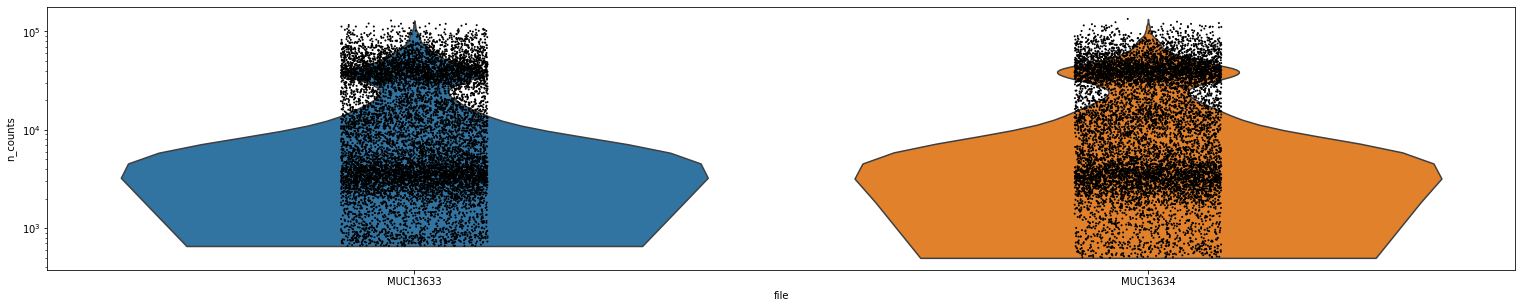

In [71]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [20]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

In [21]:
# Subset to files used for reference
files_subset=[]
for file in files:
    sample='_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Reference sample files:')
print(files_subset)

Reference sample files:
['/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/raw_feature_bc_matrix.h5ad', '/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/raw_feature_bc_matrix.h5ad']


In [22]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files_subset:
    print('Reading file',file)
    #adatas_raw.append(sc.read_h5ad(file))
    adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13633/raw_feature_bc_matrix.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/VSG_PF_WT_cohort/rev7/scanpy_AnnData/MUC13634/raw_feature_bc_matrix.h5ad


In [23]:
adata_raw

AnnData object with n_obs × n_vars = 13589760 × 31125
    obs: 'file'

In [24]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs)==1:
    adata_raw.obs['file']=file_diffs[0]

In [26]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [17]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 13570127 out of all drops: 13589760 -> remaining: 19633


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


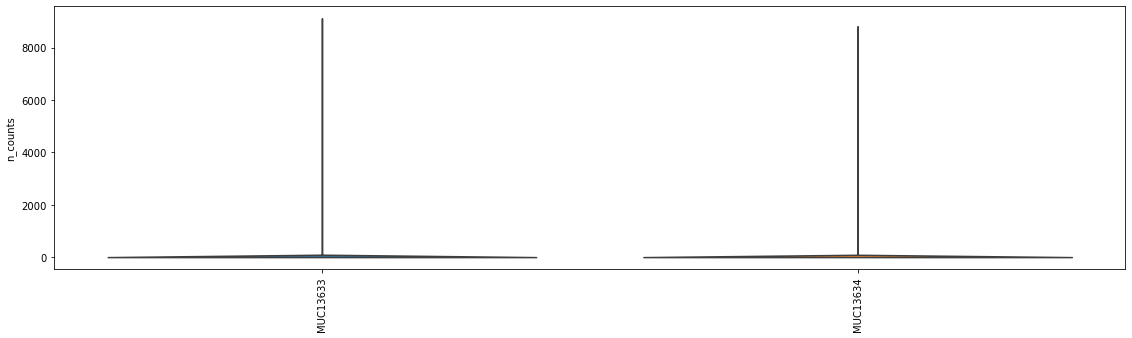

In [18]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [ ]:
#print('N cells per non-filtered sample')
#adata_raw.obs['file'].value_counts()

In [27]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

filtered out 8899545 cells that have less than 1 counts
filtered out 8956 genes that are detected in less than 1 cells


In [28]:
adata_raw

AnnData object with n_obs × n_vars = 4690215 × 22169
    obs: 'file', 'n_counts'
    var: 'n_cells'

Cell N counts sorted by cell N counts rank without all 0 cells. 

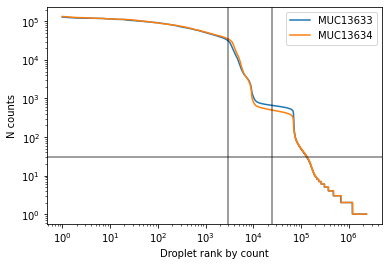

In [30]:
# For each file plot N count vs cell rank by count with log axes
fig, ax=plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')

ax.axvline(3000,c='k',alpha=0.5)
ax.axvline(25000,c='k',alpha=0.5)
ax.axhline(30,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [21]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

In [22]:
%%R -i sparse_mat -i genes -i barcodes -o ambient_scores
# Run emptyDrops and output scores per gene
sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce),BPPARAM=MulticoreParam(workers = 16))
#is_cell <- ambient$FDR <= 0.05
#threshold_ambient <- 0.005
#ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
ambient_scores <- as.data.frame(ambient@metadata$ambient)
#barcodes_filtered <- barcodes[which(is_cell)]

emptyDrops top ambient genes with scores.

In [23]:
ambient_scores.columns=['ambient_score']
ambient_scores.sort_values('ambient_score',ascending=False).query('ambient_score>=0.005')

,ambient_score
Ins2,0.288625
Ins1,0.084326
Iapp,0.025346
mt-Co3,0.019277
mt-Atp6,0.018260
mt-Co2,0.013344
Malat1,0.012219
mt-Co1,0.011420
Gcg,0.010494
mt-Cytb,0.008416


Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [24]:
ambient_vars=['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts']=adata_raw[adata_raw.obs['n_counts']<100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
Ins2       1.072544
Ins1       0.310677
Iapp       0.093493
mt-Co3     0.071129
mt-Atp6    0.067327
mt-Co2     0.049165
Malat1     0.045010
mt-Co1     0.042081
Gcg        0.038671
mt-Cytb    0.031029
Defa24     0.025655
Ppy        0.021688
Gm42418    0.021545
mt-Nd2     0.017930
mt-Nd4     0.017247
Pyy        0.011759
mt-Nd1     0.011285
Tmsb4x     0.010571
Sst        0.010094
Tpt1       0.009886
Name: mean_ambient_n_counts, dtype: float32

#C: The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [25]:
# Mean empty expression in individual samples
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts']<100)
                                                  ].X.mean(0).A1
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))][:20].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

<AxesSubplot:ylabel='index'>

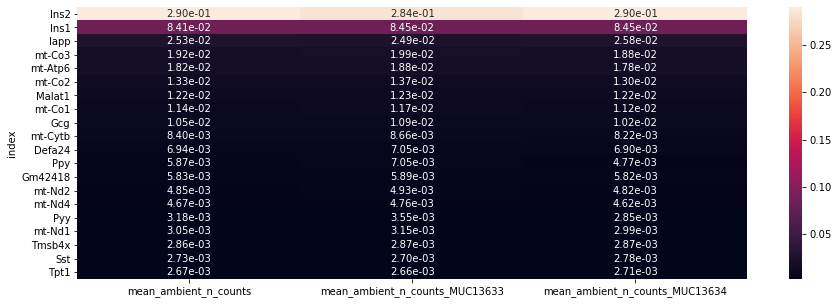

In [26]:
# Display ambient genes across samples
ambient_df=adata_raw.var[ambient_vars]
ambient_df=ambient_df.loc[ambient_genes,ambient_vars]/ambient_df.sum(axis=0)
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts',ascending=False),annot=True,fmt='.2e')

In [27]:
# Save ambient DF for top N genes
ambient_df.to_csv(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t')

In [28]:
# Save genes with scaled mean ambient expression at least > 0.005 in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>0.005).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['Iapp', 'mt-Co1', 'Ins2', 'Malat1', 'mt-Atp6', 'Ins1', 'Ppy', 'mt-Co3', 'Defa24', 'Gm42418', 'mt-Co2', 'Gcg', 'mt-Cytb']


In [63]:
del adata_raw

## QC (counts, genes, mt)

In [72]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [73]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Gcg', 'Tmsb4x', 'Cela3b', 'Cela2a', 'Cpa1', '2210010C04Rik', 'Try4', 'Try5', 'Prss2', 'Reg1', 'Iapp', 'Apoe', 'Hbb-bt', 'Hbb-bs', 'Ins2', 'Defa24', 'Ctrb1', 'Hba-a1', 'Hba-a2', 'Ccl4', 'Ppy', 'Pyy', 'Chga', 'Cela1', 'Sst', 'Clps', 'Gm26917', 'Gm42418', 'Ttr', 'Cd74', 'Malat1', 'Neat1', 'Ins1', 'Pnlip', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


computing PCA
    with n_comps=15
    finished (0:00:18)


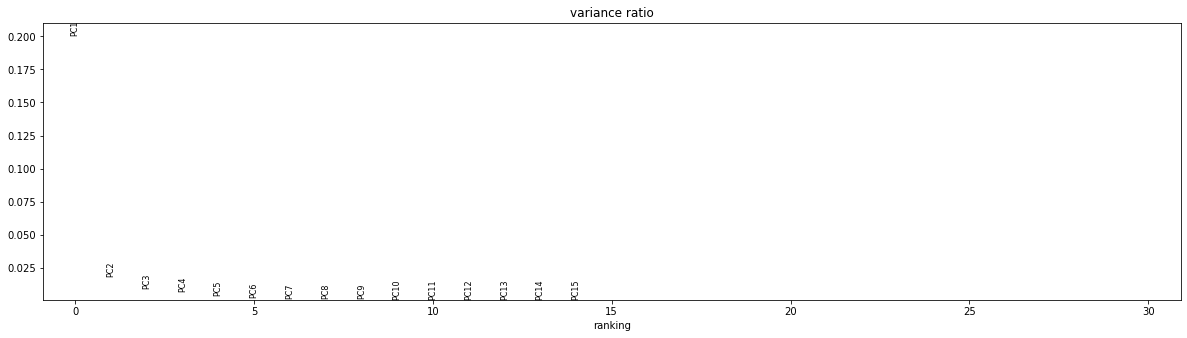

In [74]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [75]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=5, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


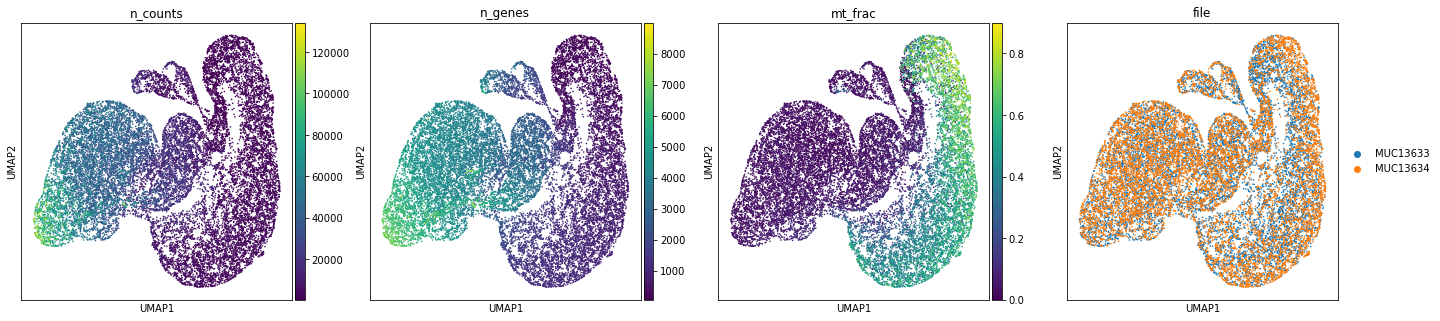

In [76]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

#C: Low n_genes and n_counts cells have high mt_frac and high n_counts cells have high n_genes. There is a subpopulation that has high n_genes but not high N_counts. Samples do not have evident batch effects.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

In [77]:
adata_temp=adata.copy()

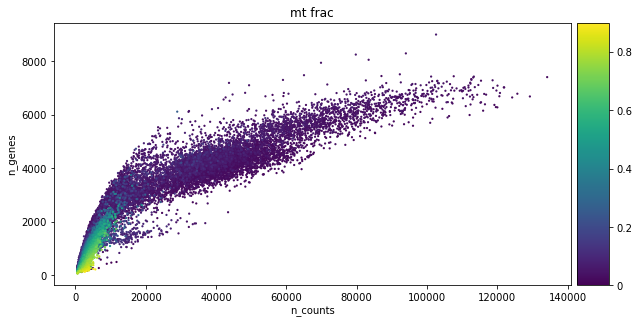

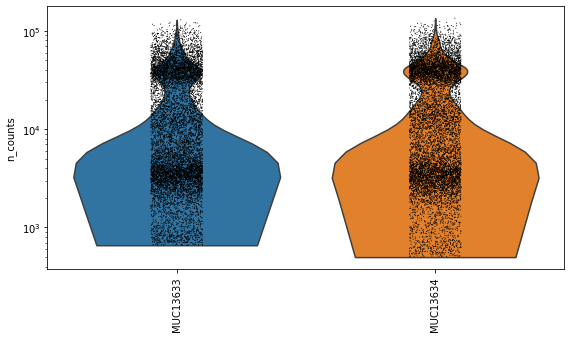

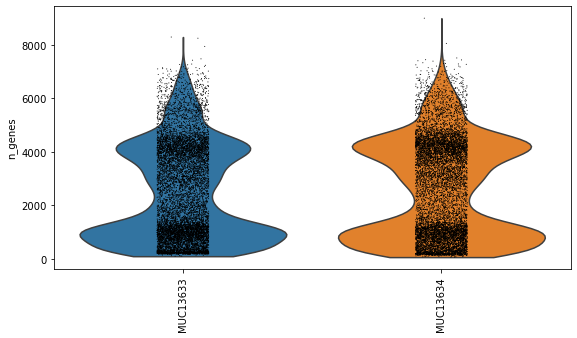

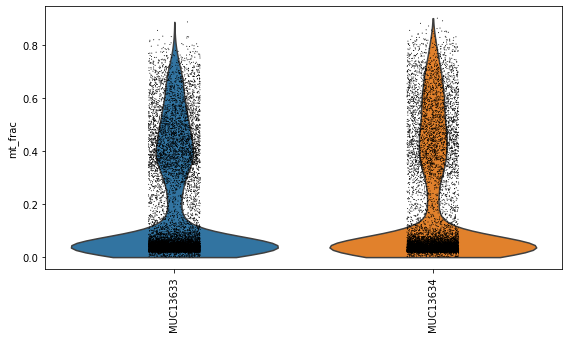

In [21]:
#Data quality summary plots
rcParams['figure.figsize']=(8,5)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

#C: There seem to be two n_counts subpopulations, with one having significantly more counts. Since it does not have that many more genes this might not be just a doublet population.

N counts:

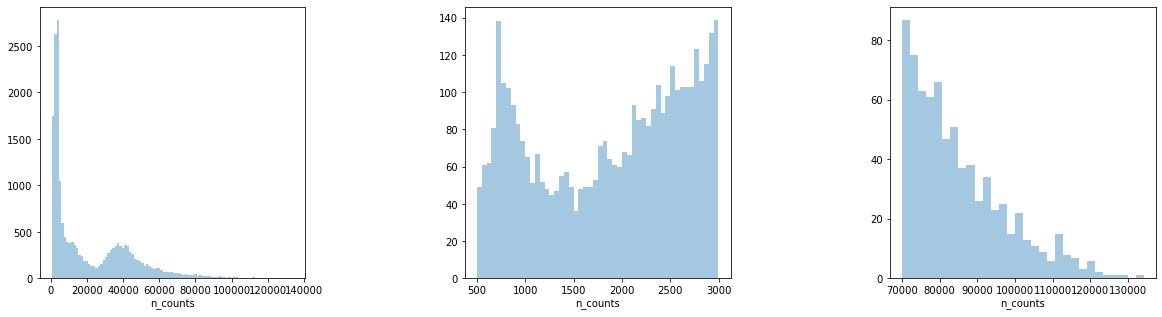

In [28]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=100)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<3000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_xscale('log')
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>70000], 
                 kde=False, bins=30, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

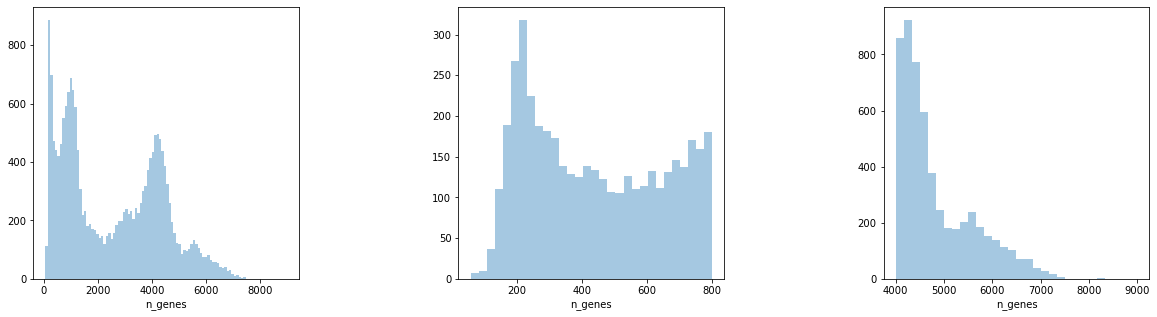

In [31]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=100, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<800], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>4000], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

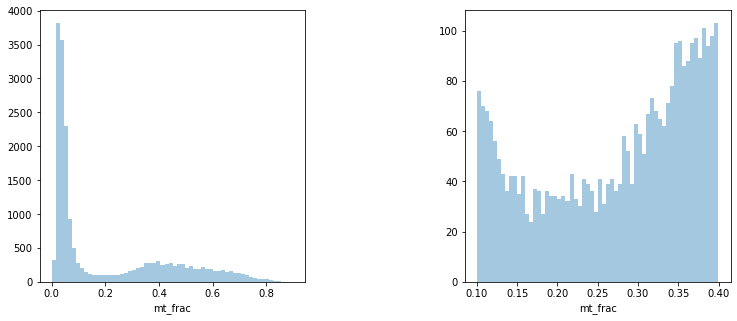

In [82]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac'].between(0.1, 0.4)], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [34]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

ok      18201
low      1384
high       48
Name: n_counts_filter, dtype: int64


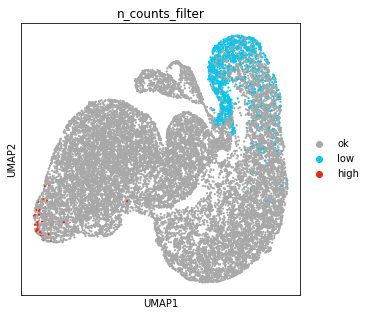

In [35]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=1500
COUNTS_THR_MAX=110000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      17039
low      2588
high        6
Name: n_genes_filter, dtype: int64


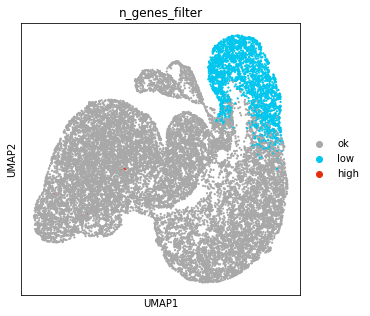

In [37]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=500
GENES_THR_MAX=7500
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

ok      12312
high     7321
Name: mt_frac_filter, dtype: int64


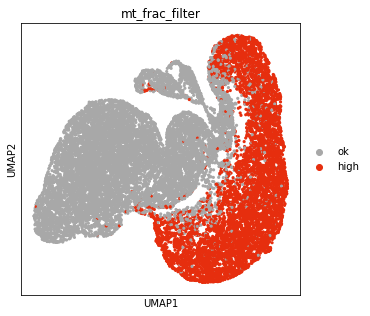

In [79]:
param='mt_frac'
MT_THR=0.17
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: Filtering out high N genes and N counts cells does not seem to be very important, as there are not many (only a couple). Doublets will be removed latter on anyway.

N cells in which a gene is expressed:

In [39]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

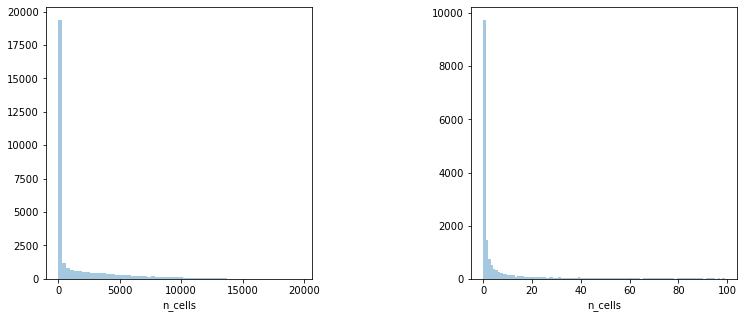

<AxesSubplot:xlabel='n_cells'>

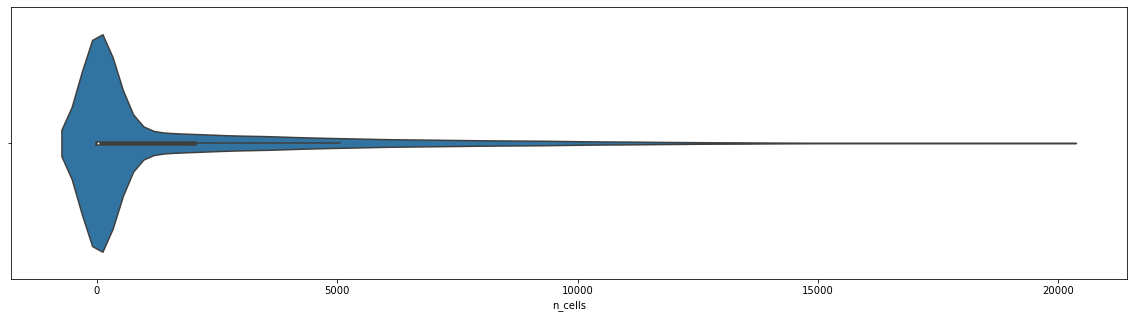

In [40]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [83]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 19633
filtered out 1384 cells that have less than 1500 counts
Number of cells after min count filter: 18249
Number of cells after MT filter: 11612
filtered out 32 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 11580


In [84]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31125
filtered out 15225 genes that are detected in less than 20 cells
Number of genes after cell filter: 15900


## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [85]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

MUC13633 N cells: 5673
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 32.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.6%
Elapsed time: 10.1 seconds
MUC13634 N cells: 5907
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 26.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.9%
Elapsed time: 10.6 seconds


Distribution of doublet scores

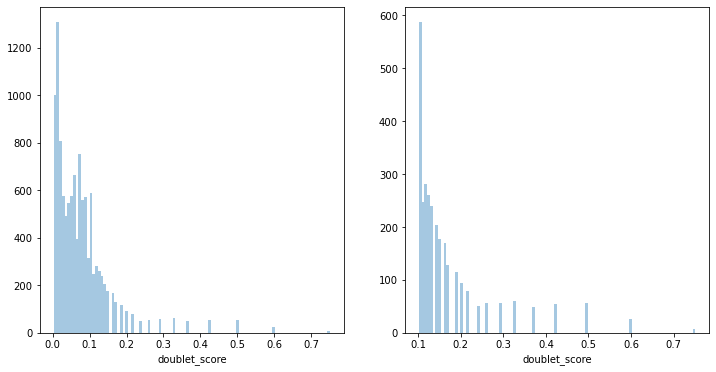

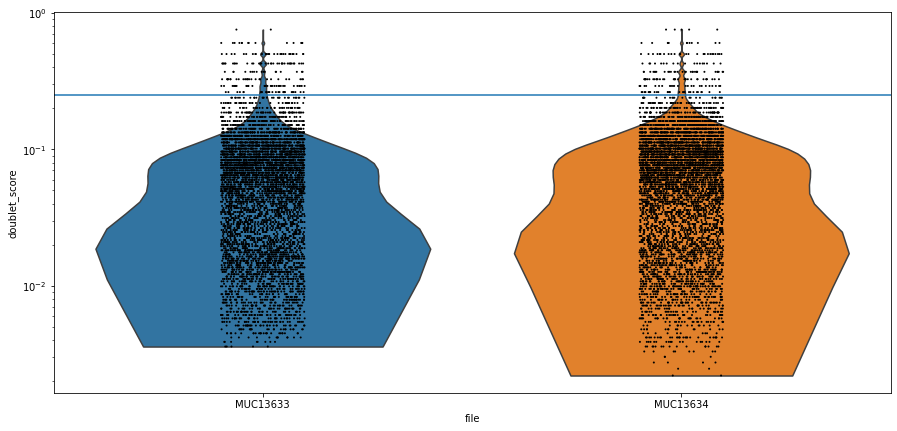

In [93]:
rcParams['figure.figsize']=(12,6)
fig,ax=plt.subplots(1,2)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False,ax=ax[0])
sb.distplot(adata[adata.obs.doublet_score>0.1].obs['doublet_score'], bins=100, kde=False,ax=ax[1])
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.25
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


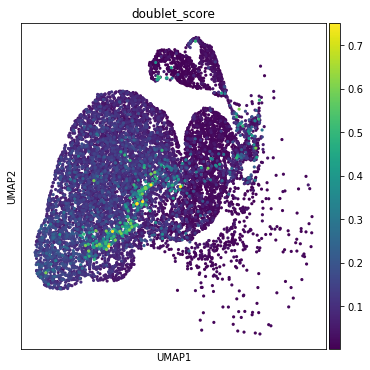

ok      11214
high      366
Name: doublet_score_filter, dtype: int64


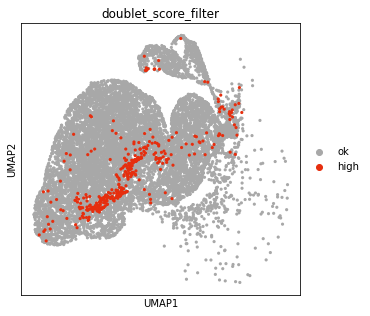

In [94]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]

# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index], color=[param+'_filter'],size=40)

#C: The high counts population does not seem to have much higher doublet scores.

#C: It seems that mt/counts/genes filtering did not remove all cells that were in high mt cluster. There might be low quality subpopulations in the data, which needs to be considered latter on.

In [95]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 11580
Number of cells after doublet filter: 11214


## Summary after QC

In [96]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
MUC13633,3680.5,3848.0,32511.2,32541.5,5486.0
MUC13634,3812.2,3986.0,34249.2,34813.5,5728.0


In [97]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 1512.0 - 134153.0
N genes range: 533 - 8998
Mt fraction range: 8.285e-04 - 1.695e-01
Doublet score range: 2.209e-03 - 2.383e-01
N cellls expressing a gene range: 20 - 11580


## Save QC data

In [98]:
# Save QC data
if SAVE:
    #adata.write(shared_folder+'data_QC.h5ad')
    h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
    #pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [99]:
# Load QC data
#adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [100]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
# Save all genes to raw
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 15900
Number of genes after ambient removal: 15887


In [101]:
adata.layers['counts'] = adata.X.copy()

In [102]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Tmsb4x', 'Cela3b', 'Cela2a', 'Cpa1', '2210010C04Rik', 'Try4', 'Prss2', 'Mgp', 'Apoe', 'Hbb-bs', 'Ctrb1', 'Ccl4', 'Pyy', 'Chga', 'Meg3', 'Cela1', 'Sst', 'Clps', 'Ttr', 'Cd74', 'Neat1', 'Pnlip', 'mt-Nd2', 'mt-Nd4']
    finished (0:00:00)
computing PCA
    with n_comps=15
    finished (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


Cluster cells for scran normalisation

In [103]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering
    finished: found 22 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:04)
N clusters: 22


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [104]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


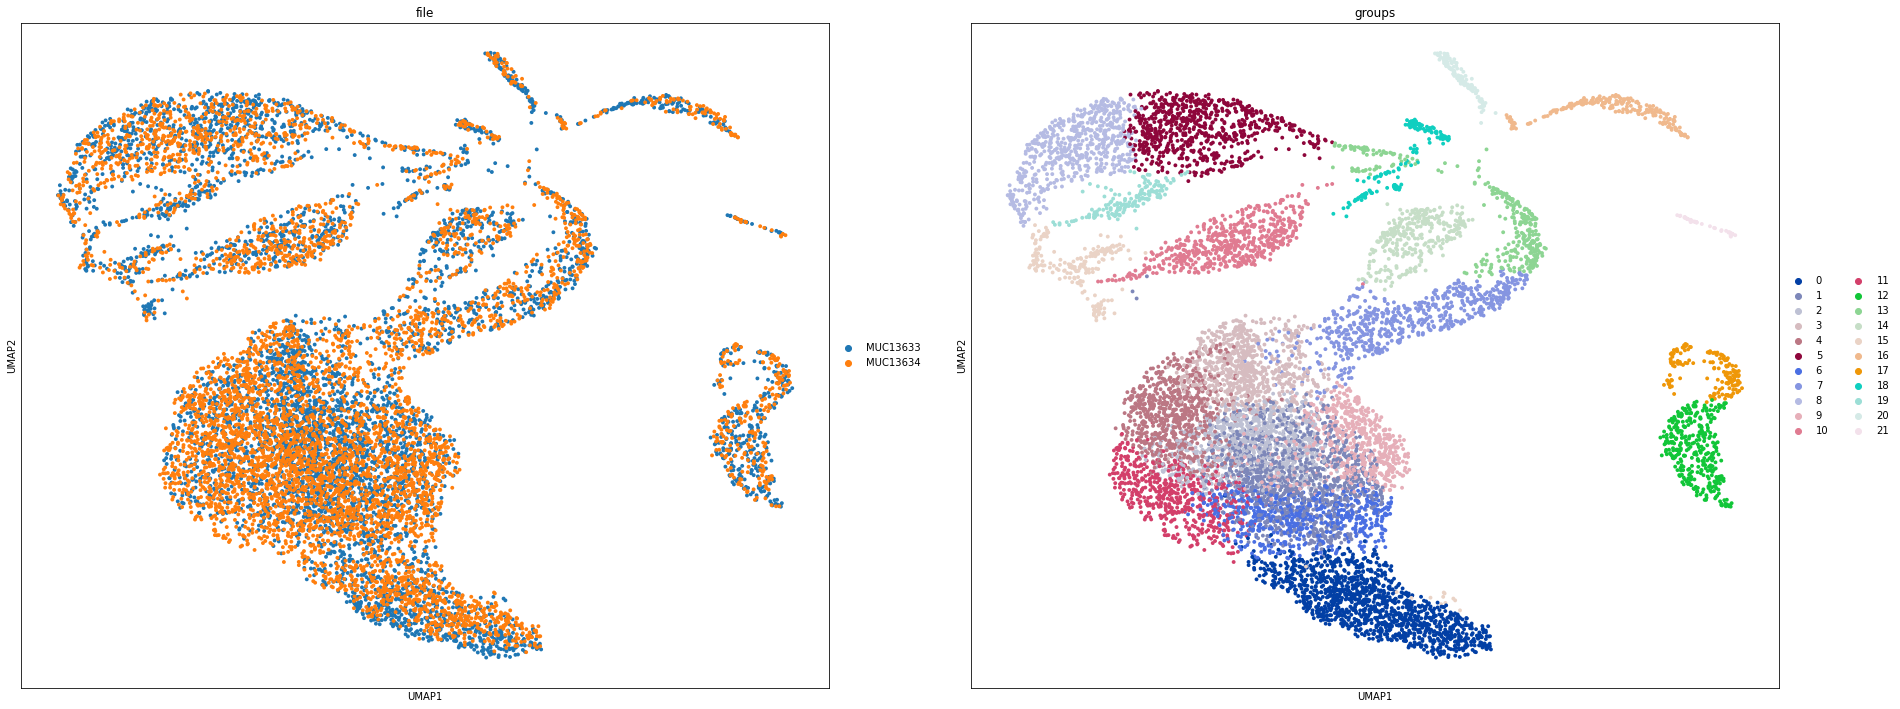

In [105]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [106]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [107]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

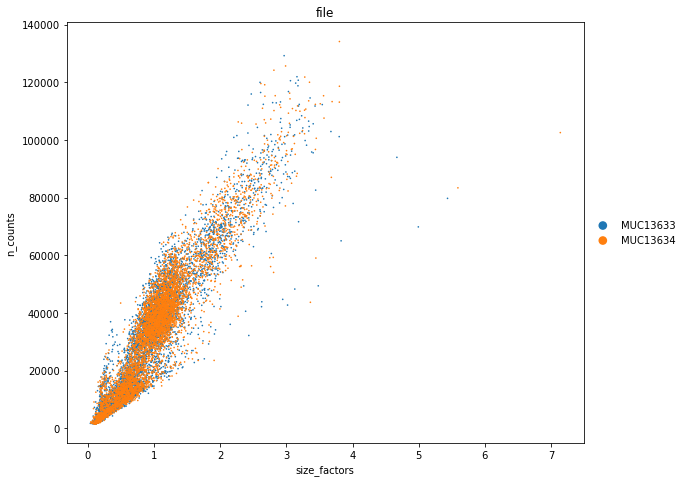

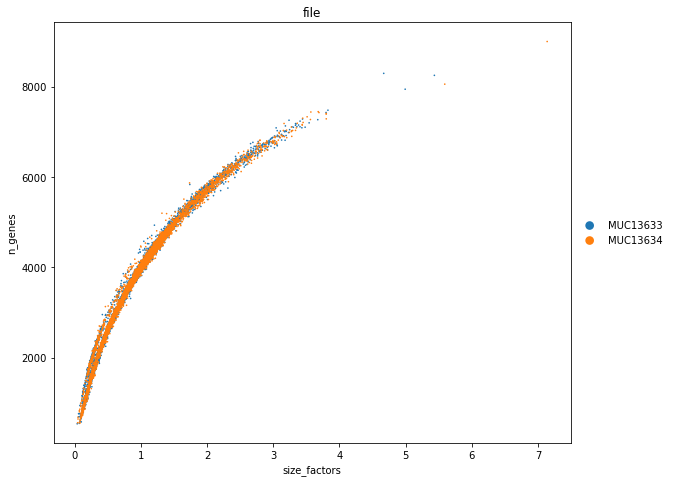

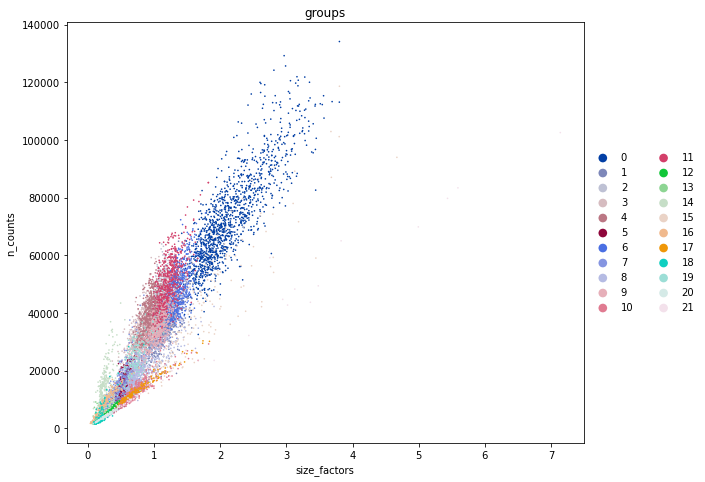

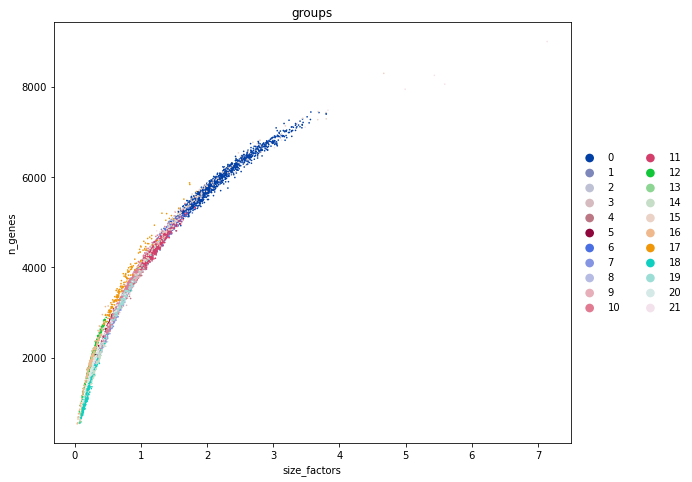

Distribution of size factors


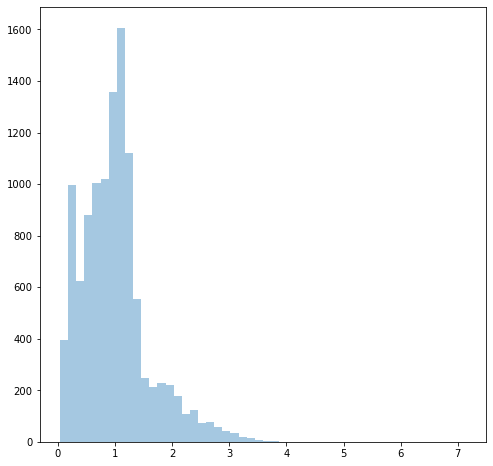

In [108]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [109]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [155]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [16]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


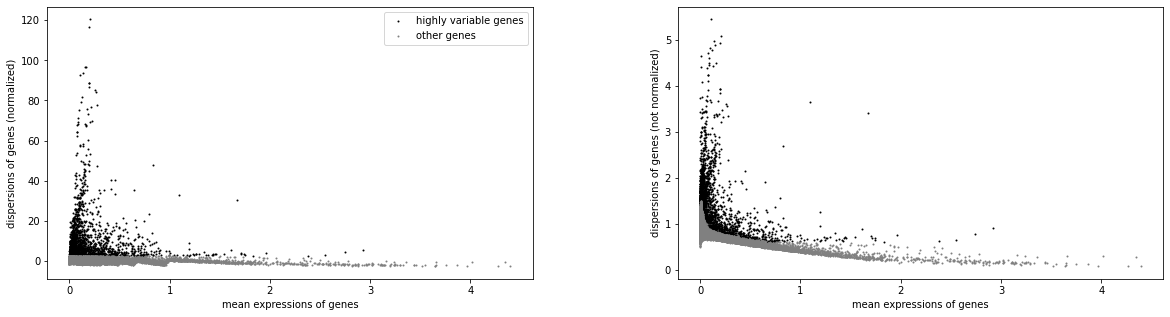

In [110]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

In [111]:
adata

AnnData object with n_obs × n_vars = 11214 × 15887
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'doublet_score_filter_colors', 'file_colors', 'mt_frac_filter_colors', 'log1p'
    layers: 'counts'

## Save normalised data

In [22]:
# Used due to problems with saving h5ad
#pickle.dump( adata, open( shared_folder+"data_normalised.pkl", "wb" ) )

In [112]:
if SAVE:
    #adata.write(shared_folder+"data_normalised.pkl")
    h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)

In [20]:
#adata_temp=adata.copy()
#adata=adata_temp.copy()

In [21]:
#adata_temp.write('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/scanpy_AnnData/data_processed_temp.h5ad')